# <div style="background-color: #153B50; font-family: Trebuchet MS; color: #FFFFFF; padding: 5px; font-size: 150%; text-align: center; line-height: 1; border-radius: 10px 10px;">Time-Series Analysis</div>

---

We'll begin an analysis based on time series, focusing primarily on hourly energy use, with the **PJME_hourly** data set given by PJM, a regional transmission organization in the United States. This data set shows a detailed record of energy use in eastern America from January 2002 to August 2018.

Let us begin our exploration of energy utilization patterns...

# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Import Library Required</div>

**Tools & Libraries:**
This analysis will employ a variety of Python libraries, including:

- `pandas` and `numpy` for data processing and numerical computation.
- `matplotlib` and `seaborn` are used to visualize trends and data patterns.
- `xgboost` to create an ensamble learning model.
- `fbprophet` is for implementing Facebook's Prophet model.
- `sklearn` provides extra modeling tools and performance indicators.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import xgboost
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", FutureWarning)

print("Module loaded")

Module loaded


**Objective:**

The goal of this notebook is to apply machine learning techniques to predict time series in order to accurately forecast future energy use. By performing historical data analysis in the PJME_hourly dataset, we will aim to:

- Identifying and displaying energy usage trends and patterns.
- Identifying seasons, trends, and anomalies in energy consumption.
- Comparing the predictive capabilities of **XGBoost** and **Facebook's Prophet**, three approaches for time series prediction, to measure their usefulness and accuracy in predicting energy consumption.

**Methodology:**

This examination will go through several key stages, including:

1. **Processing Data**: Preparing data sets for analysis by removing errors and missing values.
2. **Exploratory Data Analysis (EDA)**: In-depth investigation of data sets to find trends, patterns, and insights.
3. **Functional Engineering**: Creating features to improve the accuracy of model predictions.
4. **Modelling**: Developing and refining predictive models to forecast energy use by hour.
5. **Evaluation and Comparison**: Assessing model performance with appropriate measures and comparing forecasting accuracy on invisible data.

# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Read Datasets</div>

In [2]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')

**General Data Set:**

The **PJME_hourly** data collection provides a complete overview of historical data on energy use that has been meticulously documented every hour for over 16 years. This vast time horizon enables for a thorough assessment of consumption trends, such as seasonal changes and long-term swings in energy demand. Analyzing these datasets can provide significant insights into the dynamics of energy consumption, which is critical for effective energy management and distribution.

# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Data Preprocessing</div>

In [3]:
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">EDA</div>

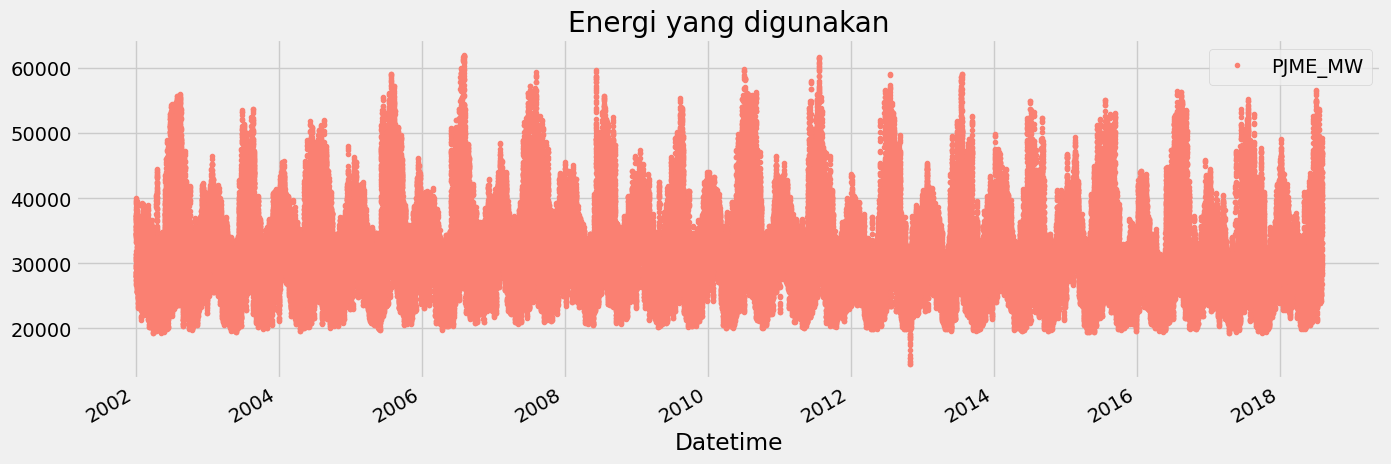

In [4]:
plt.style.use("fivethirtyeight")

# dataset image plot
df.plot(
    style= ".",
    figsize= (15, 5),
    color= "salmon",
    title= "Energi yang digunakan"
)
plt.show()

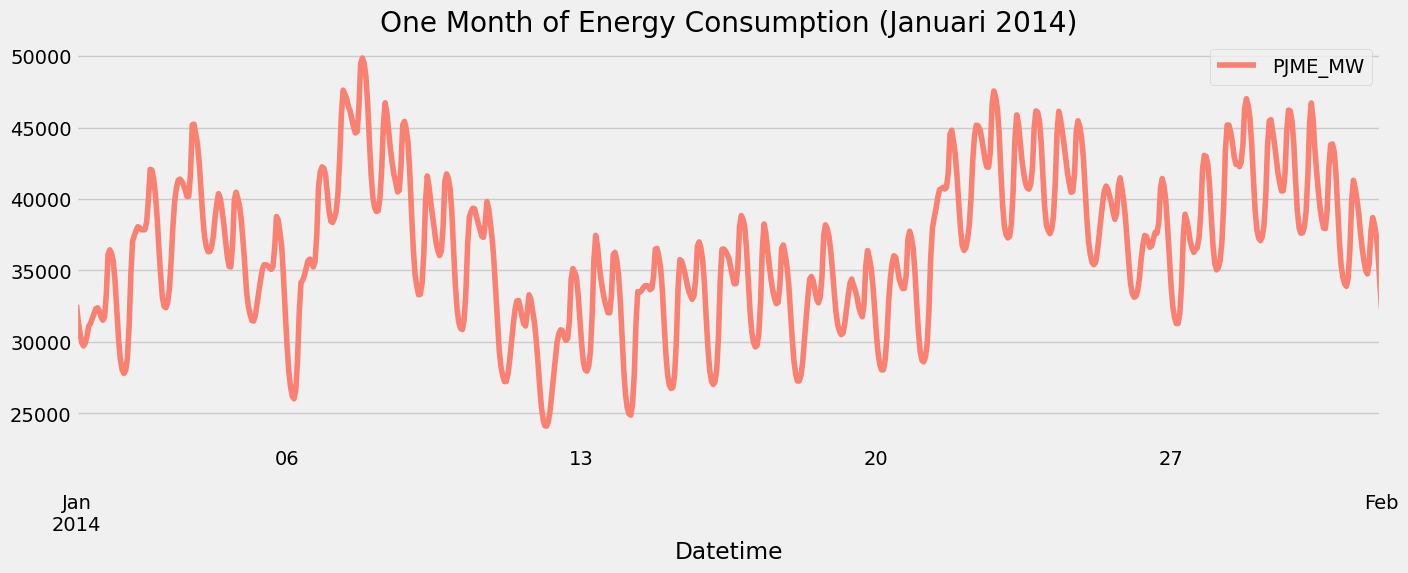

In [5]:
# get for a month
one_month = df.loc[(df.index >= "2014-01-01") & (df.index <= "2014-02-01")]

# plot
one_month.plot(
    style= "-",
    figsize= (15, 5),
    color= "salmon",
    title= "One Month of Energy Consumption (Januari 2014)"
)
plt.show()

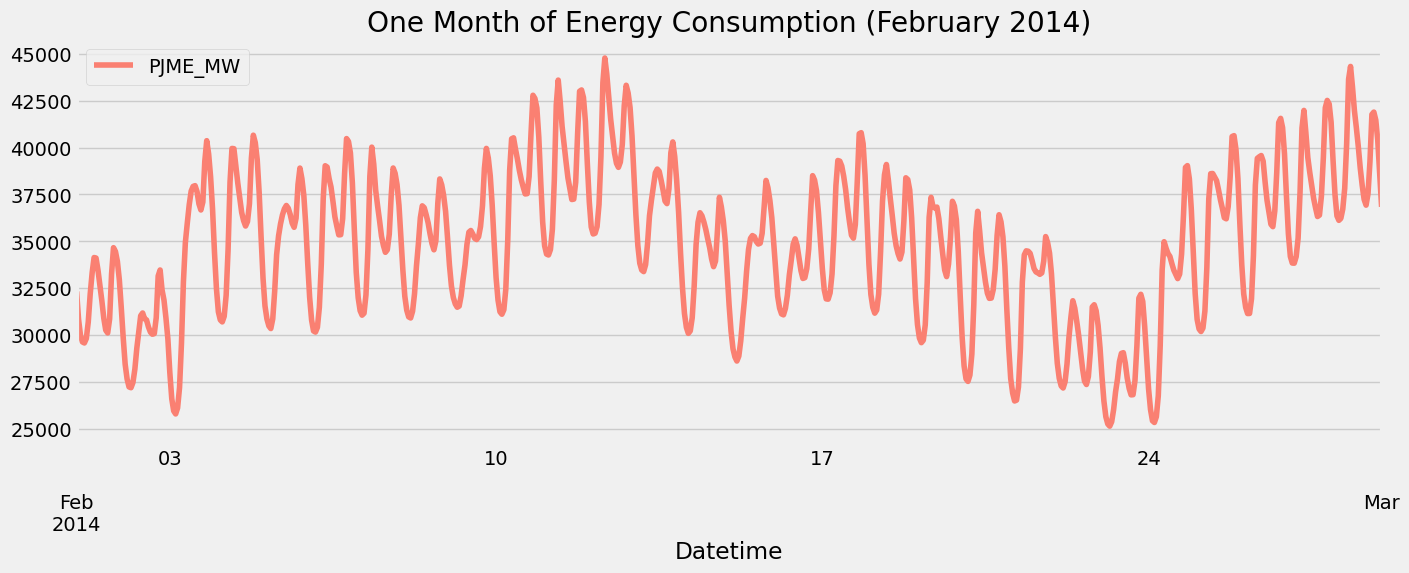

In [6]:
one_month = df.loc[(df.index >= "2014-02-01") & (df.index <= "2014-03-01")]

# plot
one_month.plot(
    style= "-",
    figsize= (15, 5),
    color= "salmon",
    title= "One Month of Energy Consumption (February 2014)"
)
plt.show()

In a nutshell, the utilization of each month does not appear to be consistent.

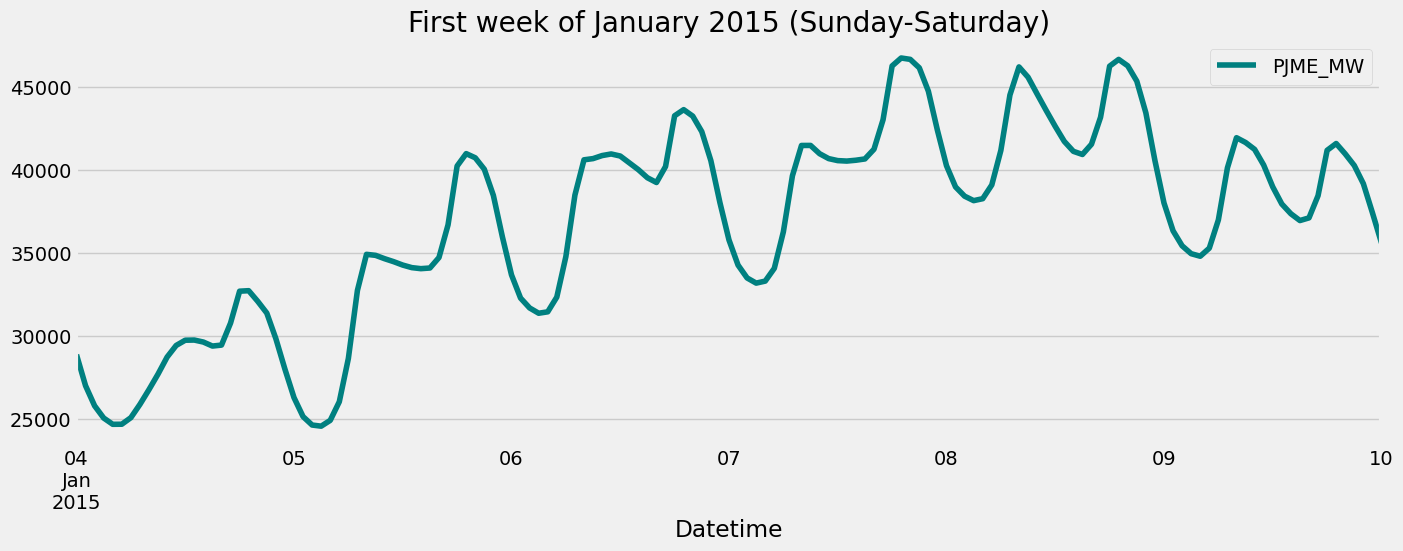

In [7]:
# get for a week
one_week = df.loc[(df.index >= '2015-01-04') & (df.index <= '2015-01-10')]

# plot
one_week.plot(
    figsize=(15, 5),
    title="First week of January 2015 (Sunday-Saturday)",
    color='teal'
)
plt.show()

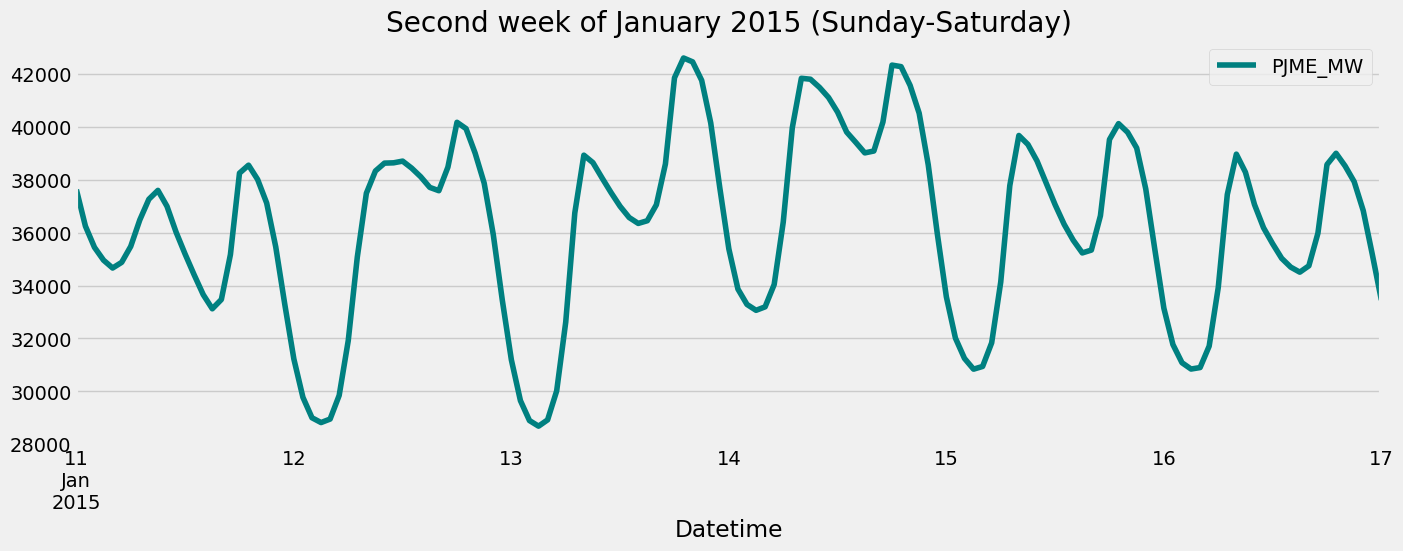

In [8]:
# Let's see in week two
one_week = df.loc[(df.index >= '2015-01-11') & (df.index <= '2015-01-17')]

# plot
one_week.plot(
    figsize=(15, 5),
    title="Second week of January 2015 (Sunday-Saturday)",
    color='teal'
)
plt.show()

In a nutshell, if you look at them daily, they look more like each other than weekly.

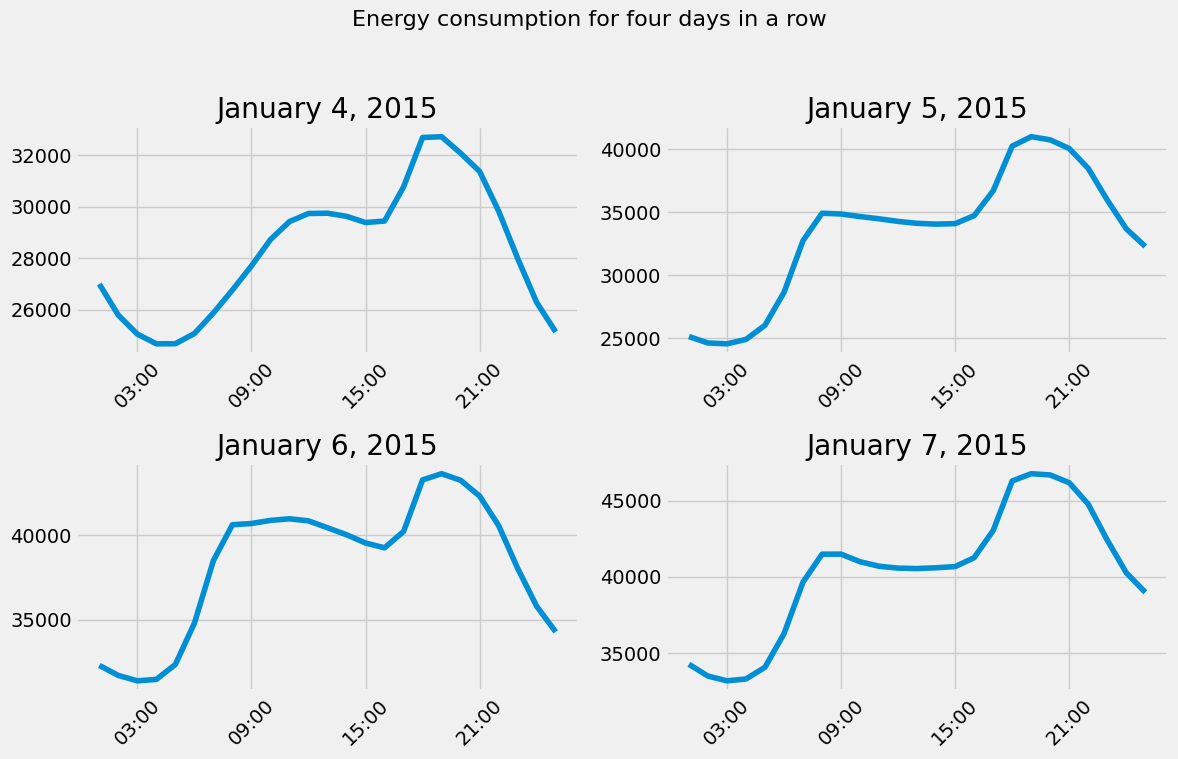

In [9]:
# get for a day
day_one = df.loc[(df.index >= '2015-01-04 01:00:00') & (df.index <= '2015-01-05 01:00:00')]
day_two = df.loc[(df.index >= '2015-01-05 01:00:00') & (df.index <= '2015-01-06 01:00:00')]
day_three = df.loc[(df.index >= '2015-01-06 01:00:00') & (df.index <= '2015-01-07 01:00:00')]
day_four = df.loc[(df.index >= '2015-01-07 01:00:00') & (df.index <= '2015-01-08 01:00:00')]

days = [day_one, day_two, day_three, day_four]
day_labels = ['January 4, 2015', 'January 5, 2015', 'January 6, 2015', 'January 7, 2015']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Energy consumption for four days in a row', fontsize=16)

axes = axes.flatten()

for i, day in enumerate(days):
    axes[i].plot(day.index, day['PJME_MW'])
    axes[i].set_title(day_labels[i])
    
    axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Although the range of energy usage on a given day fluctuates significantly, the overall pattern of daily consumption stays consistent.

# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Train & Test Set</div>

In [10]:
# data splitting
def split_data(df, date= "01-01-2015"):
    train = df.iloc[df.index < date]
    test = df.iloc[df.index >= date]
    return train, test

In [11]:
train, test = split_data(df)

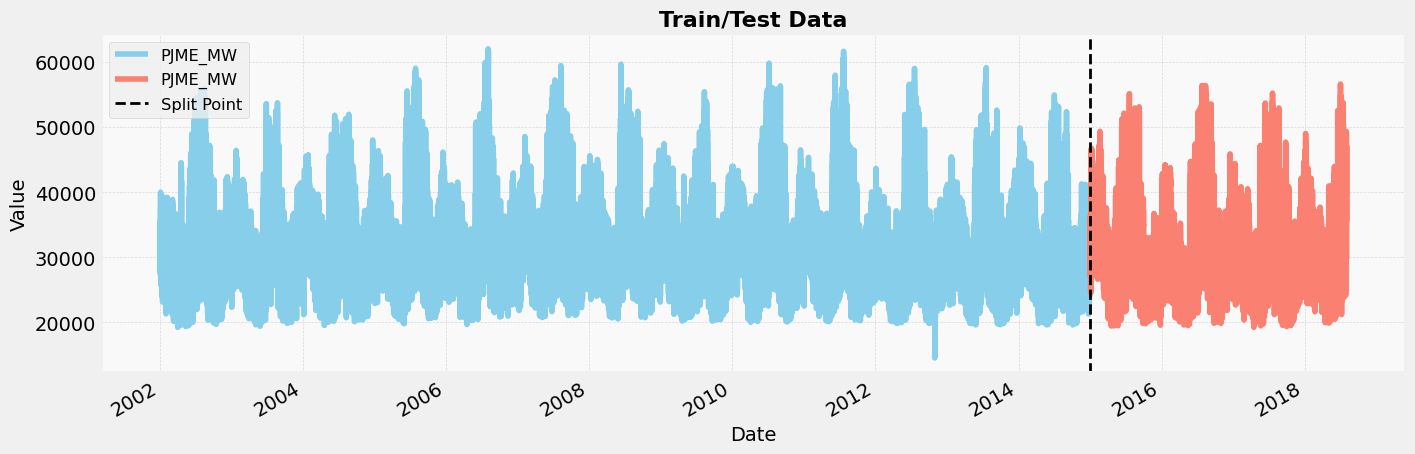

In [12]:
# visualization of train and test data
fig, ax = plt.subplots(figsize= (15, 5))

train.plot(ax=ax, color="skyblue", label="Train Set")
test.plot(ax=ax, color="salmon", label="Test Set")

ax.axvline(pd.to_datetime("01-01-2015"), color="black", ls="--", lw=2, label="Split Point")

ax.set_title("Train/Test Data", fontsize=16, fontweight="bold")
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.legend(fontsize="small", loc="upper left")
plt.grid(True, linestyle="--", linewidth=.5, alpha=.7)
ax.set_facecolor("#F9F9F9")

plt.show()

# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Feature Generation</div>

In [13]:
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    df["weekofyear"] = df.index.isocalendar().week
    return add_holidays(df)

def add_holidays(df, country="US"):
    df = df.copy()
    holiday_list = holidays.CountryHoliday(country)
    
    # make a column with "0" for workdays and "1" for offdays
    df["holiday"] = df.index.map(lambda x: x in holiday_list).astype(int)
    return df

df_original = df.copy()
df = create_features(df)
df = add_holidays(df)

In [14]:
natal = df.loc[df.index == "2015-12-25"]
tahun_baru = df.loc[df.index == "2016-01-01"]
random_day = df.loc[df.index == "2016-01-02"]

print("Christmas", natal["holiday"])
print("New Year", tahun_baru["holiday"])
print("Non-holiday", random_day["holiday"])

Christmas Datetime
2015-12-25    1
Name: holiday, dtype: int64
New Year Datetime
2016-01-01    1
Name: holiday, dtype: int64
Non-holiday Datetime
2016-01-02    0
Name: holiday, dtype: int64


# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Feature/Target Relationship</div>

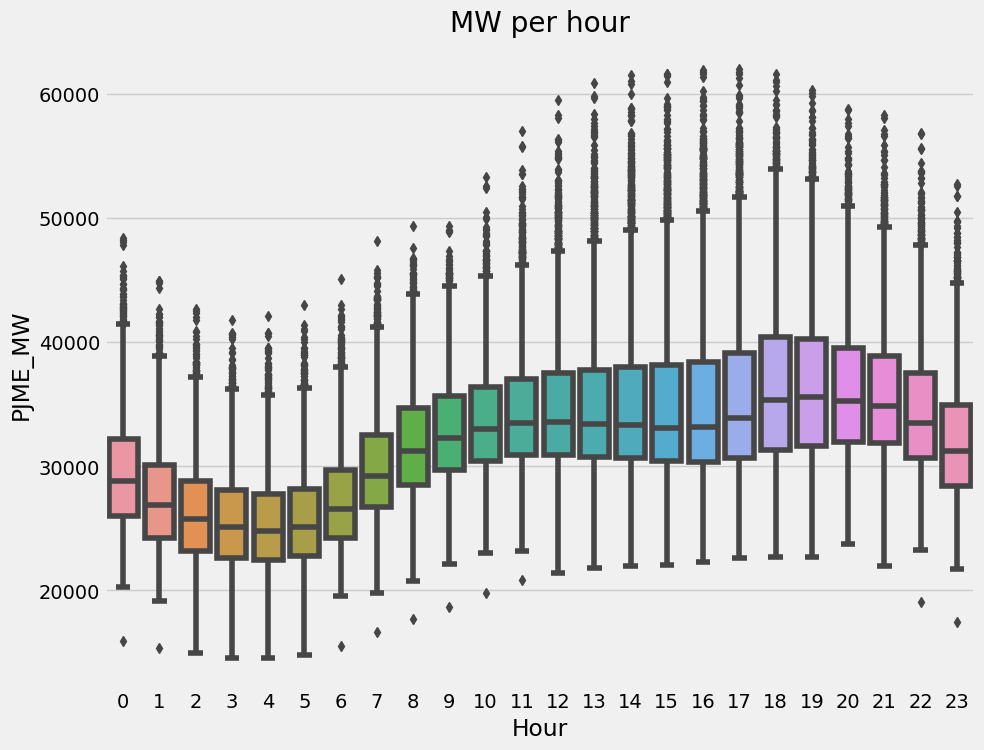

In [15]:
# distribution for every hour per day
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x="hour", y="PJME_MW")
ax.set_title("MW per hour")
ax.set_xlabel("Hour")
plt.show()

Energy consumption peaked around 6 p.m. and subsequently fell to a low at 4 a.m.

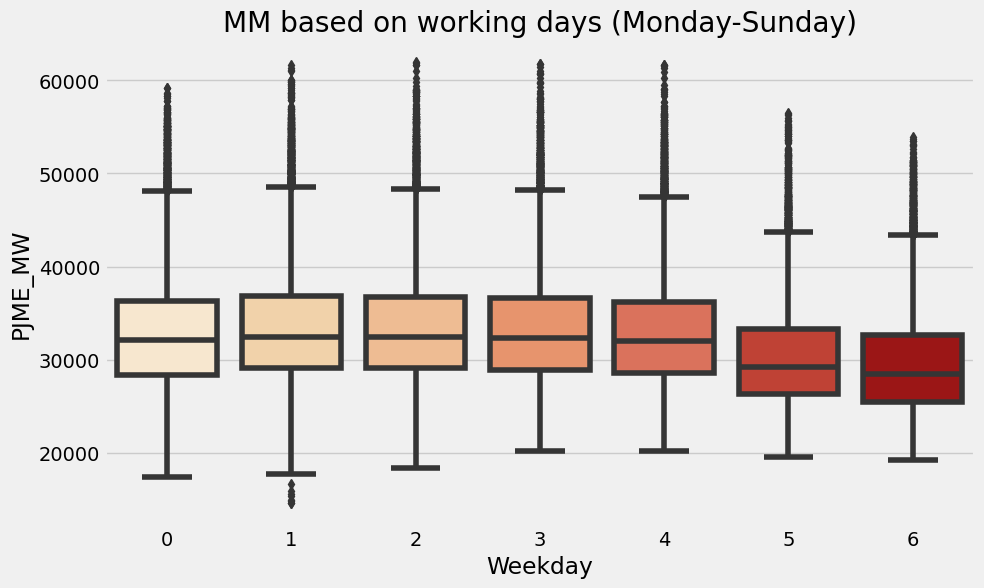

In [16]:
# daily distribution based on a week
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x="dayofweek", y="PJME_MW", palette="OrRd")
ax.set_xlabel("Weekday")
ax.set_title("MM based on working days (Monday-Sunday)")
plt.show()

Weekends have much lower energy consumption levels. This is likely due to the shutdown of large business buildings, which require more power to operate than residential homes.

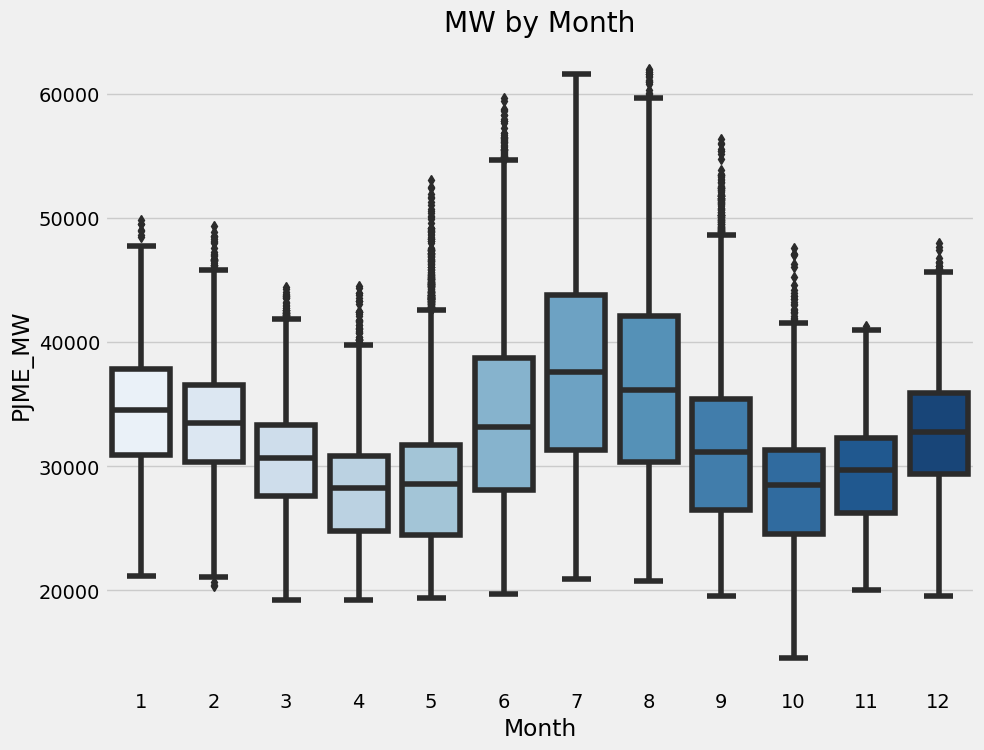

In [17]:
# distribution every month
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x="month", y="PJME_MW", palette="Blues")
ax.set_title("MW by Month")
ax.set_xlabel("Month")
plt.show()

Obviously, there are seasonal effects that may be produced by more intense weather during the height of winter or summer, resulting in more energy being consumed for heating and air conditioning.

# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Data Preparation</div>

In [18]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'holiday', 'weekofyear', 'dayofmonth']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Using XGBoost to Predict Energy Usage</div>

XGBoost is an effective and scalable machine learning technique that use a gradient enhancement framework to construct a sequential tree with the goal of correcting prior errors. It integrates predictions from all trees to enhance accuracy while also incorporating regularization to avoid overfitting. The Xgboost ensemble technique, which employs several decision trees, can capture complicated patterns in data, making it useful for a range of predictive modeling tasks.

**Why should I use it for time series forecasting?** XGBoost is successful for timeline predictions because its ensemble method captures temporal dependencies and nonlinear correlations in the data, and its regularization features assist prevent overfitting against previous trends, resulting in robust predictions for future observations.

## <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">XGBoost Parameters</div>

**base_score**: the initial prediction score of all instances, before any improvement (tree) is made. It's like an initial guess for the model.

**booster**: This parameter determines the type of model that will be run at each iteration. This could be gbtree (tree-based model), gblinear (linear model), or dart (Dropout meets Multiple Additive Regression Trees). gbtree is the most commonly used.

**n_estimators**: This is the number of increased rounds or number of trees to be built. The more trees can produce more complex models, which may be more accurate but may also be too fit.

**early_stopping_rounds**: This parameter is used to stop training if the validation score stops increasing during the specified number of enhancement rounds. Here, set to 50, which means if the performance of the model on the validation set does not increase for 50 rounds in a row, the training will be stopped.

**objective**: This defines the loss function to be minimized. In your code, reg:linear is used for regression tasks with a linear goal function. Note that in newer versions of XGBoost, reg:linear has been replaced by reg:squarederror.

**max_depth**: This controls the maximum depth of trees. Deeper trees can model more complex relationships, but can also cause overfitting.

**learning_rate**: Also known as eta, this parameter reduces the weight of the feature to make the upgrade process more conservative. Smaller learning speeds require larger improvement rounds, but can produce better models because they provide more powerful solutions.

In [19]:
reg = xgboost.XGBRegressor(
    base_score=.5, booster="gbtree",
    n_estimators=1300,
    early_stopping_rounds=50,
    objective="reg:squarederror",
    max_depth=3,
    learning_rate=.01,
)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100,
)

# verbose 100 shows the MSE score every 100 iterations
# model training iteration will stop when the RMSE score is low

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35068	validation_1-rmse:11747.06148
[200]	validation_0-rmse:5835.20181	validation_1-rmse:5360.72049
[300]	validation_0-rmse:3925.11161	validation_1-rmse:4000.24579
[400]	validation_0-rmse:3444.22348	validation_1-rmse:3852.67686
[500]	validation_0-rmse:3284.59846	validation_1-rmse:3813.00701
[600]	validation_0-rmse:3198.96492	validation_1-rmse:3781.67010
[700]	validation_0-rmse:3139.87615	validation_1-rmse:3759.89566
[800]	validation_0-rmse:3098.91216	validation_1-rmse:3742.83419
[900]	validation_0-rmse:3063.75768	validation_1-rmse:3730.97889
[1000]	validation_0-rmse:3033.21299	validation_1-rmse:3723.94876
[1100]	validation_0-rmse:3005.49902	validation_1-rmse:3721.06745
[1200]	validation_0-rmse:2982.71993	validation_1-rmse:3716.81267
[1253]	validation_0-rmse:2970.96974	validation_1-rmse:3718.50988


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Feature Importance</div>

XGBoost comes with a method that shows how much the change contributes in each feature to the change in the target variable.

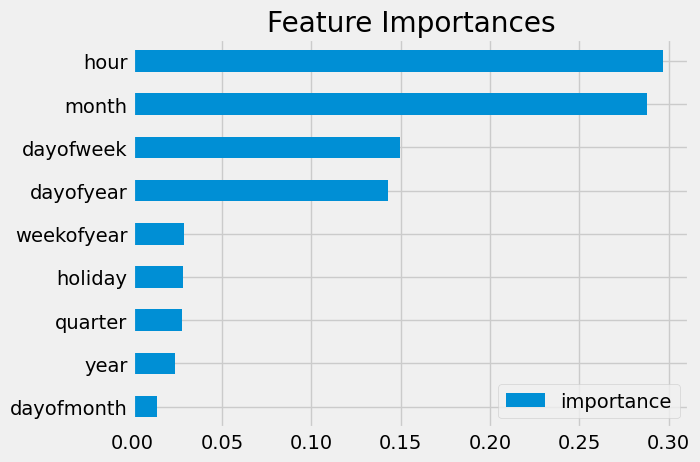

In [20]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["importance"]
)

fi.sort_values("importance").plot(kind="barh", title="Feature Importances")
plt.show()

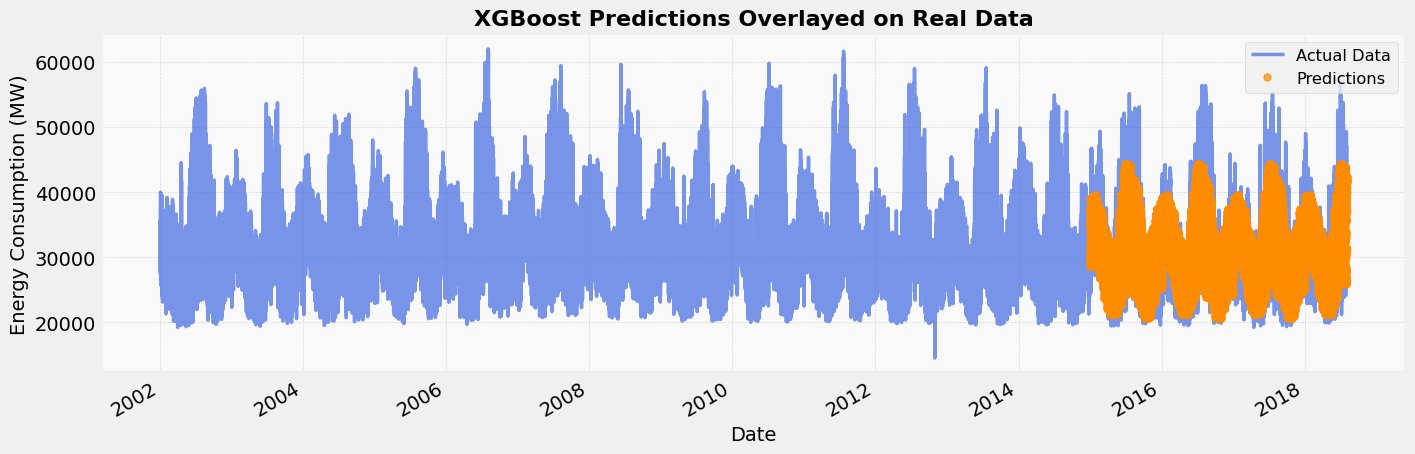

In [21]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# plot original data
ax = df[['PJME_MW']].plot(figsize=(15, 5), linewidth=2.5, linestyle='-', color='royalblue', alpha=0.7)

# plot prediction
df['prediction'].plot(ax=ax, style='o', markersize=5, color='darkorange', alpha=0.7)

plt.legend(['Actual Data', 'Predictions'], fontsize='small')
ax.set_title('XGBoost Predictions Overlayed on Real Data', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Energy Consumption (MW)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('#f9f9f9')  # Light background color for the plot area

plt.show()

# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Error Metrics</div>

**Mean Absolute Error (MAE)** <br />
MAE calculates the size of the average error in a set of predictions, regardless of direction. It is derived by averaging the absolute difference between the expected and actual values. Unlike RMSE, the MAE considers all errors equally and provides a linear estimate of error magnitude. It is also in the same unit as the observed data, making it easy to grasp. A smaller MAE means that the model is more accurate.

**RMSE (Root Mean Square Error)** <br />
RMSE is a widely used metric that calculates the square root of the average square difference between the expected and actual values. This technique lends greater weight to larger errors, making it extremely sensitive to outliers in the prediction series. Unlike MAE, which treats all errors equally, **RMSE imposes a higher penalty for large-scale errors**, offering a more diverse image of the model's performance, particularly on undesirable datasets for making large-sized errors. It is expressed in the same units as the observed data, allowing for an intuitive grasp of the degree of the inaccuracy. Lower RMSE values suggest a more accurate model, particularly in avoiding large errors.

**Nean Absolute Percentage Error (MAPE)** <br />
MAPE represents the average percentage of absolute error between the projected and actual values, providing a relative measure of prediction error in percentages. It provides measurements that are not scale-dependent, making it useful for comparing model accuracy across multiple data scales. However, MAPE can be very deviant because its actual value is near to zero and it is not defined for zero, restricting its applicability. Lower Mape values suggest improved model performance.

In [22]:
# function for mape
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
mae_score = mean_absolute_error(test['PJME_MW'], test['prediction'])
print(f'Mean Absolute Error Score : {mae_score:0.2f}')

Mean Absolute Error Score : 2875.03


In [24]:
rmse_score = sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score : {rmse_score:0.2f}')

RMSE Score : 3716.79


In [25]:
mape_score = mape(test['PJME_MW'], test['prediction'])
print(f'Mean Absolute Percentage Error Score : {mape_score:0.2f}')

Mean Absolute Percentage Error Score : 9.04


# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Using Prophet from Facebook to Predict Energy Consumption</div>

In [26]:
# reset dataframe
df = df_original.copy()
train, test = split_data(df)

Prophet takes a certain data format which is not datetime but 'ds'. We have to convert our data back to datetime.

In [27]:
# data format for Prophet models using ds and y
prophet_train = train.reset_index() \
    .rename(columns={'Datetime':'ds','PJME_MW':'y'})
prophet_train.head()

,ds,y
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0


**Notes on Prophet Before Creating Features** <br />
Prophet does not utilize time characteristics in the same manner as xgboost. Prophet automatically models trends, seasons (daily, weekly, annual), and holidays, but it does not take arbitrary features like "hours in a day" as XGBoost does. However, this is intended to incorporate holiday days by including the 'holidays' column in the data framework. To ensure that models are equally compared, we will include holidages for Prophet.


In [28]:
cal = calendar()

df['date'] = df.index.date
df['is_holiday'] = df.date.isin([d.date() for d in cal.holidays()])
holiday_df = df.loc[df['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2002-01-01 01:00:00,USFederalHoliday
1,2002-01-01 02:00:00,USFederalHoliday
2,2002-01-01 03:00:00,USFederalHoliday
3,2002-01-01 04:00:00,USFederalHoliday
4,2002-01-01 05:00:00,USFederalHoliday


In [29]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [30]:
prophet_model = Prophet(holidays=holiday_df)
prophet_model.fit(prophet_train)

07:26:22 - cmdstanpy - INFO - Chain [1] start processing
07:29:46 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# predict
prophet_fcst = prophet_model.predict(df=test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [32]:
prophet_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,USFederalHoliday,USFederalHoliday_lower,USFederalHoliday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,31263.761899,24332.092811,33297.298162,31263.761899,31263.761899,-1839.94345,-1839.94345,-1839.94345,-2486.707263,...,1298.687352,1298.687352,1298.687352,466.976984,466.976984,466.976984,0.0,0.0,0.0,28777.054637
1,2015-01-01 01:00:00,31263.724936,22525.667796,31307.487772,31263.724936,31263.724936,-1839.94345,-1839.94345,-1839.94345,-4509.642364,...,1292.582793,1292.582793,1292.582793,468.275898,468.275898,468.275898,0.0,0.0,0.0,26754.082571
2,2015-01-01 02:00:00,31263.687972,21214.160448,29867.213918,31263.687972,31263.687972,-1839.94345,-1839.94345,-1839.94345,-6012.823936,...,1284.803067,1284.803067,1284.803067,469.612489,469.612489,469.612489,0.0,0.0,0.0,25250.864036
3,2015-01-01 03:00:00,31263.651008,19513.772813,28872.594254,31263.651008,31263.651008,-1839.94345,-1839.94345,-1839.94345,-6883.716634,...,1275.461156,1275.461156,1275.461156,470.986786,470.986786,470.986786,0.0,0.0,0.0,24379.934373
4,2015-01-01 04:00:00,31263.614044,19760.993296,28488.509135,31263.614044,31263.614044,-1839.94345,-1839.94345,-1839.94345,-7024.928447,...,1264.690197,1264.690197,1264.690197,472.398818,472.398818,472.398818,0.0,0.0,0.0,24238.685597


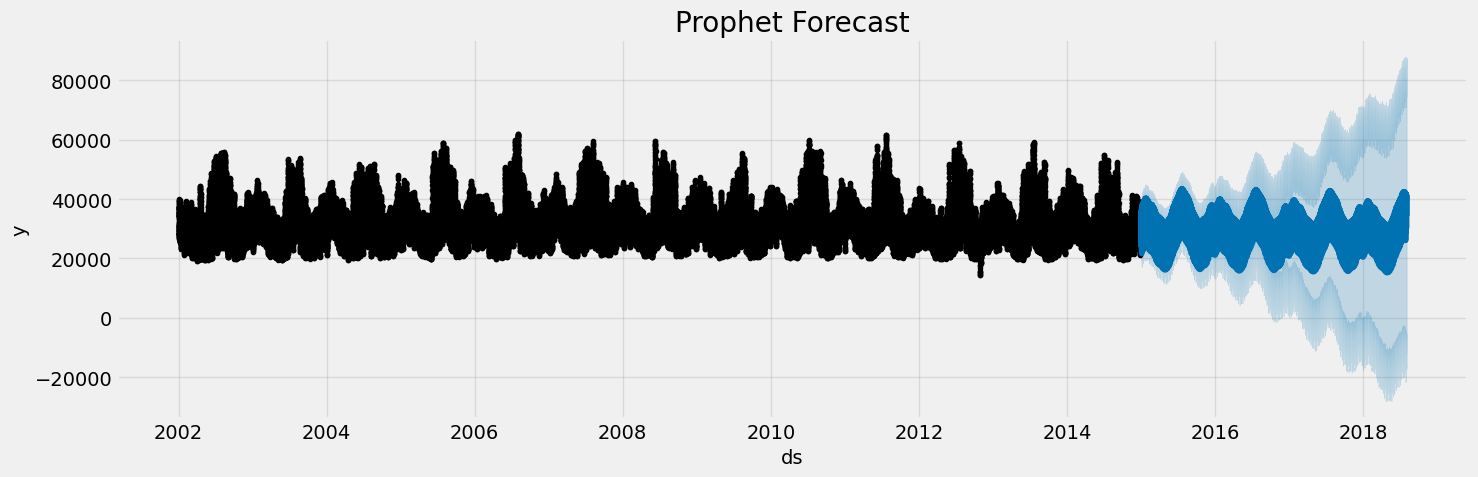

In [33]:
# plot prediction result
f, ax = plt.subplots(1)
ax.set_title('Prophet Forecast')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Konsumsi Energi (MW)', fontsize=14)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet_model.plot(prophet_fcst,ax=ax)
plt.show()

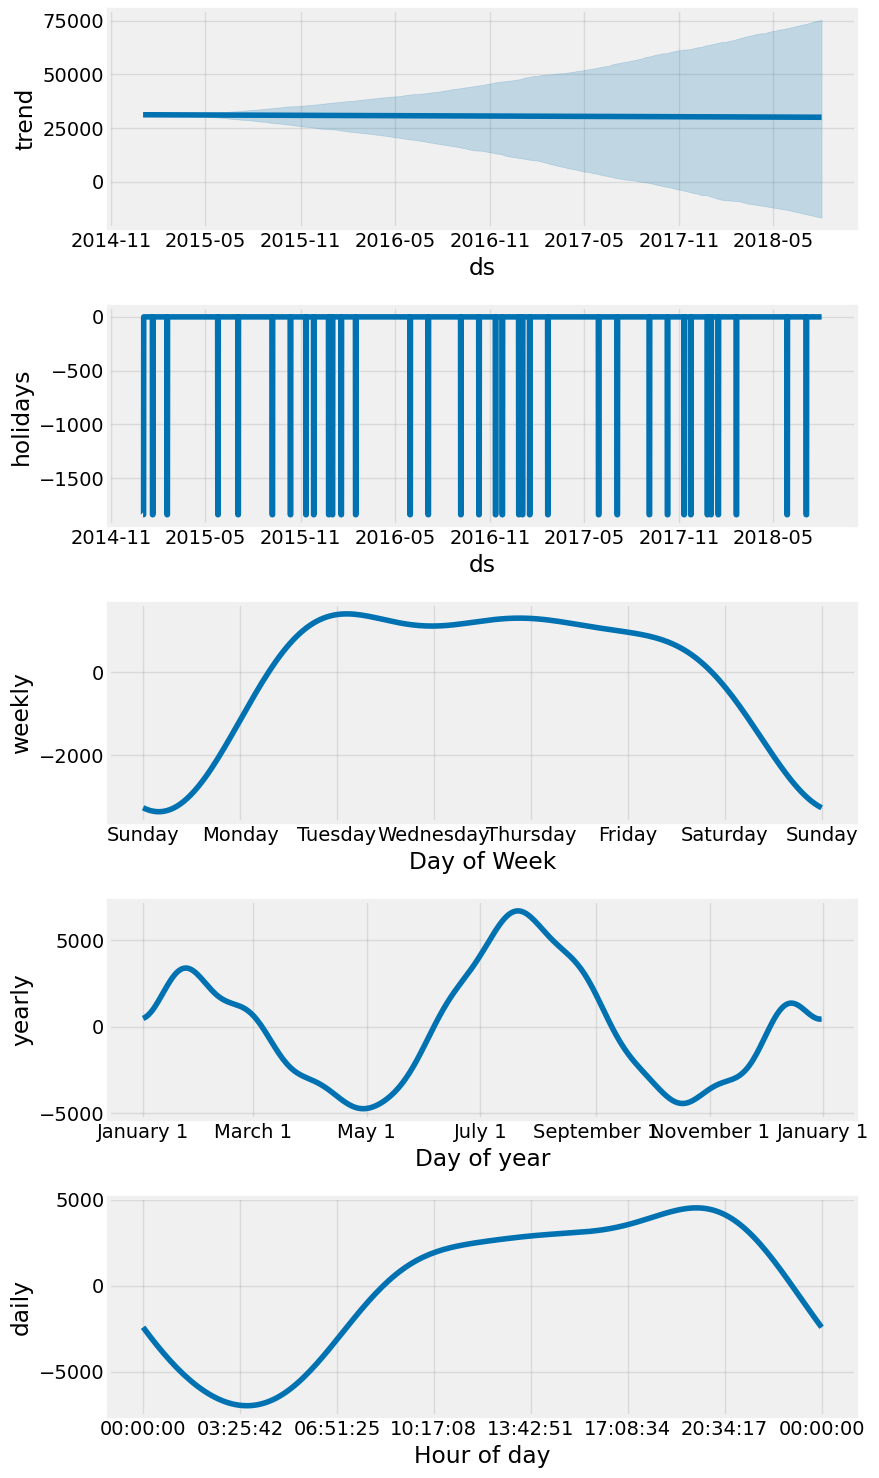

In [34]:
# plot model components
fig = prophet_model.plot_components(prophet_fcst)

# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Comparison of Predicted Results with Actual Values</div>

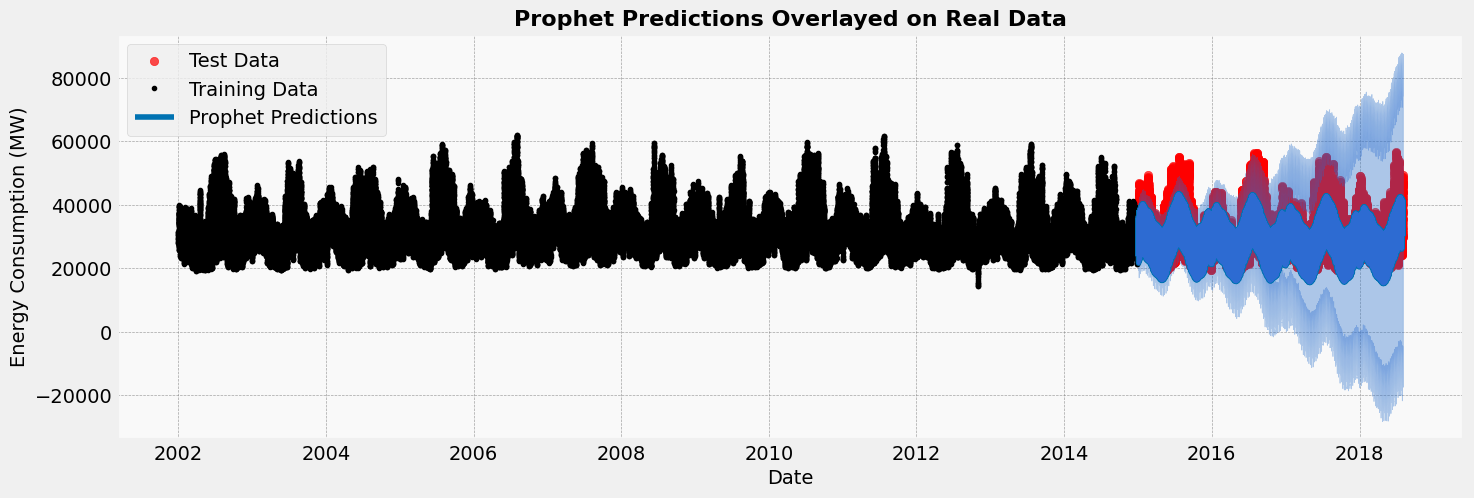

In [35]:
# set up plot
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# actual plot of test data
ax.scatter(test.index, test['PJME_MW'], color='red', alpha=0.7, label='Real Data')

fig = prophet_model.plot(prophet_fcst, ax=ax, plot_cap=False)

# plot Prophet forecasts
ax.plot(prophet_fcst['ds'], prophet_fcst['yhat'], color='royalblue', linewidth=2.5, alpha=0.7, label='Prophet Predictions')
ax.fill_between(prophet_fcst['ds'], prophet_fcst['yhat_lower'], prophet_fcst['yhat_upper'], color='royalblue', alpha=0.2)

ax.set_title('Prophet Predictions Overlayed on Real Data', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Energy Consumption (MW)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('#f9f9f9')  # Light background color for the plot area
plt.legend(['Test Data', 'Training Data', 'Prophet Predictions'], fontsize='medium', loc='upper left')

plt.show()

# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Prophet Model Error Metrics</div>

In [36]:
prophet_MAE = mean_absolute_error(test['PJME_MW'], prophet_fcst['yhat'])
print(f'Mean Absolute Error Score : {prophet_MAE:0.2f}')

Mean Absolute Error Score : 3102.92


In [37]:
prophet_rmse = sqrt(mean_squared_error(test['PJME_MW'], prophet_fcst['yhat']))
print(f'RMSE Score on : {prophet_rmse:0.2f}')

RMSE Score on : 4116.50


In [38]:
prophet_MAPE = mape(test['PJME_MW'], prophet_fcst['yhat'])
print(f'Mean Absolute Percent Error Score : {prophet_MAPE:0.2f}')

Mean Absolute Percent Error Score : 9.62


# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Summary of Findings</div>

In this extensive investigation of hourly energy consumption forecasting, we assess and compare the efficacy of two advanced forecasting algorithms, XGBoost and Prophet. Our evaluation is based on three key metrics: mean absolute error (MAE), root mean square error (RMSE), and mean absolute percentage error (MAPE). The following are the summary findings.

XGBost Performance:
- **MAE**: 2875.03
- **RMSE**: 3716.79
- **MAPE**: 9.04%

XGBoost displayed high performance across all criteria, proving its ability to handle time series data. XGBoost's low MAE and RMSE values suggest accurate predictions, with fewer and more significant errors. The MAPE number demonstrates its percentage accuracy, making it an effective model for this forecasting assignment.

**Prophet Show**:
- **MAE**: 3102.92
- **RMSE**: 4116.50
- **MAPE**: 9.62%

Prophet, produced by Facebook, likewise performs admirably but falls slightly below XGBoost in this examination. Higher MAE and RMSE values suggest Prophet's predictions are less accurate than XGBoost's, showing a larger average error. The somewhat larger MAPE demonstrates that, while Prophet remains effective, it is less accurate on a percentage basis than XGBoost.

# <div style="font-family: Trebuchet MS; background-color: #153B50; color: #FFFFFF; padding: 12px; line-height: 1.5;">Conclusion</div>

Both XGBoost and Prophet proved to be useful tools for estimating hourly energy consumption, with each having its own set of advantages. Xgboost surpasses Prophet in terms of MAE, RMSE, and MAPE, indicating that it may be a better fit for precision-oriented applications. The findings emphasize the importance of model selection in time series estimates, as well as the efficacy of machine learning techniques in predicting energy consumption trends.

**Potential next step** <br />
Combining lag values is a promising approach for improving the accuracy of time series estimates. By using previous observations as features, we can better capture temporal dependencies. This, together with additional model parameter tweaks, has the potential to dramatically increase our prediction capabilities. Experimenting with different intervals and altering model settings can lead to a better grasp of the underlying patterns in our data, ultimately improving our estimations.